In [1]:
import sys
sys.path.append("/usr/local/lib/python3.7/site-packages")
sys.path.append("/Library/Python/3.7/site-packages")

In [2]:
import numpy as np
import meep as mp
from autograd import numpy as npa
import meep.adjoint as mpa
from matplotlib import pyplot as plt

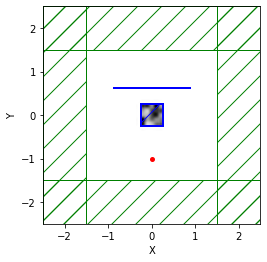

Starting forward run...
Starting adjoint run...
Calculating gradient...


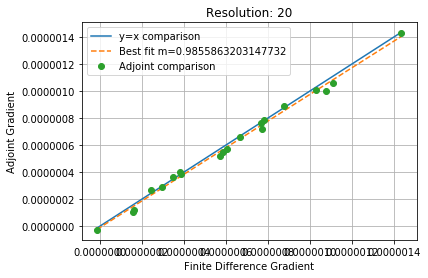

In [3]:
mp.quiet(quietval=True)
seed = 24
#np.random.seed(seed)

resolution = 20

Sx = 5
Sy = 5
sxy = 5
cell_size = mp.Vector3(Sx,Sy)

pml_layers = [mp.PML(1.0)]

fcen = 1/1.55
width = 0.2
fwidth = width * fcen
source_center  = [0,-1,0]
source_size    = mp.Vector3(0,0,0)
src = mp.GaussianSource(frequency=fcen,fwidth=fwidth)

source = [mp.Source(src,component=mp.Ex,
                    size = source_size,
                    center=source_center)]


design_region_resolution = 10

Nx = design_region_resolution//2
Ny = design_region_resolution//2

Si = mp.Medium(index=3.4)
SiO2 = mp.Medium(index=1.44)

design_variables = mp.MaterialGrid(mp.Vector3(Nx,Ny),SiO2,Si,grid_type='U_SUM')
design_region = mpa.DesignRegion(design_variables,volume=mp.Volume(center=mp.Vector3(), size=mp.Vector3(0.5, 0.5, 0)))




geometry = [
    mp.Block(center=design_region.center, size=design_region.size, material=design_variables)# design region
]


sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=source,
                    eps_averaging=False,
                    resolution=resolution)

far_x = mp.Vector3(2000, 2000, 0)
NearRegions = [mp.Near2FarRegion(center=mp.Vector3(0,+0.125*sxy), size=mp.Vector3(0.35*sxy,0), weight=+1)]


Far0 = mpa.Far_Coefficients(sim, NearRegions ,far_x)


ob_list = [Far0]




def J2(alpha):
    return npa.abs(alpha[0,0])**2 + npa.abs(alpha[1,5])**3


def J1(alpha):
    return npa.abs(alpha[0,0])**2


def J3(alpha):
    return npa.abs(alpha[0,0])**2 + npa.abs(alpha[0,5])**3




opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=J1,
    objective_arguments=ob_list,
    design_regions=[design_region],
    #design_variables=[design_variables],
    fcen=fcen,
    df = 0,
    nf = 1,
    decay_fields=[mp.Ex]
)




x0 = 11*np.random.rand(Nx*Ny) + 1
opt.update_design([x0])



opt.plot2D(True,frequency=1/1.55)
plt.show()



f0, dJ_deps = opt()



db = 1e-3
choose = 20

g_discrete, idx = opt.calculate_fd_gradient(num_gradients=choose,db=db)
g_discrete = np.array(g_discrete)

#g_adjoint = np.sum(design_variables.get_basis_vjp(dJ_deps,dg), axis=1)

g_adjoint = dJ_deps
(m, b) = np.polyfit(np.squeeze(g_discrete), g_adjoint[idx], 1)
min_g = np.min(g_discrete)
max_g = np.max(g_discrete)
        
plt.figure()
plt.plot([min_g, max_g],[min_g, max_g],label='y=x comparison')
plt.plot([min_g, max_g],[m*min_g+b, m*max_g+b],'--',label='Best fit m='+str(m))
plt.plot(g_discrete,g_adjoint[idx],'o',label='Adjoint comparison')
plt.xlabel('Finite Difference Gradient')
plt.ylabel('Adjoint Gradient')
plt.title('Resolution: {}'.format(resolution))
plt.legend()
plt.grid(True)
plt.show()







Starting forward run...
Starting adjoint run...
Calculating gradient...


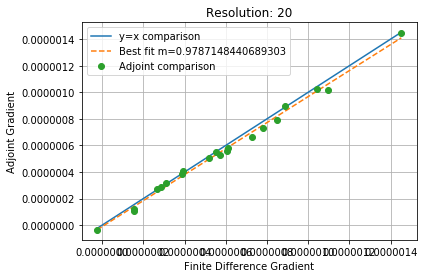

In [4]:

opt.objective_functions=[J3]

f0, dJ_deps = opt()



db = 1e-3
choose = 20

g_discrete, idx = opt.calculate_fd_gradient(num_gradients=choose,db=db)
g_discrete = np.array(g_discrete)

#g_adjoint = np.sum(design_variables.get_basis_vjp(dJ_deps,dg), axis=1)

g_adjoint = dJ_deps
(m, b) = np.polyfit(np.squeeze(g_discrete), g_adjoint[idx], 1)
min_g = np.min(g_discrete)
max_g = np.max(g_discrete)
        
plt.figure()
plt.plot([min_g, max_g],[min_g, max_g],label='y=x comparison')
plt.plot([min_g, max_g],[m*min_g+b, m*max_g+b],'--',label='Best fit m='+str(m))
plt.plot(g_discrete,g_adjoint[idx],'o',label='Adjoint comparison')
plt.xlabel('Finite Difference Gradient')
plt.ylabel('Adjoint Gradient')
plt.title('Resolution: {}'.format(resolution))
plt.legend()
plt.grid(True)
plt.show()





Starting forward run...
Starting adjoint run...


/usr/local/lib/python3.7/site-packages/meep/adjoint/filter_source.py:89: RuntimeWarning: divide by zero encountered in true_divide
  l2_err = np.sum(np.abs(H-H_hat)**2/np.abs(H)**2)
/usr/local/lib/python3.7/site-packages/meep/adjoint/filter_source.py:89: RuntimeWarning: invalid value encountered in true_divide
  l2_err = np.sum(np.abs(H-H_hat)**2/np.abs(H)**2)


Calculating gradient...


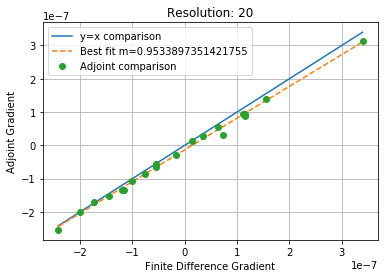

In [5]:
opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=J2,
    objective_arguments=ob_list,
    design_regions=[design_region],
    #design_variables=[design_variables],
    fcen=fcen,
    df = 0.03,
    nf = 3,
    decay_fields=[mp.Ex]
)


f0, dJ_deps = opt()



db = 1e-3
choose = 20

g_discrete, idx = opt.calculate_fd_gradient(num_gradients=choose,db=db)
g_discrete = np.array(g_discrete)


g_adjoint = np.sum(dJ_deps, axis=1)
(m, b) = np.polyfit(np.squeeze(g_discrete), g_adjoint[idx], 1)
min_g = np.min(g_discrete)
max_g = np.max(g_discrete)
        
plt.figure()
plt.plot([min_g, max_g],[min_g, max_g],label='y=x comparison')
plt.plot([min_g, max_g],[m*min_g+b, m*max_g+b],'--',label='Best fit m='+str(m))
plt.plot(g_discrete,g_adjoint[idx],'o',label='Adjoint comparison')
plt.xlabel('Finite Difference Gradient')
plt.ylabel('Adjoint Gradient')
plt.title('Resolution: {}'.format(resolution))
plt.legend()
plt.grid(True)
plt.show()



Starting forward run...
Starting adjoint run...
Calculating gradient...


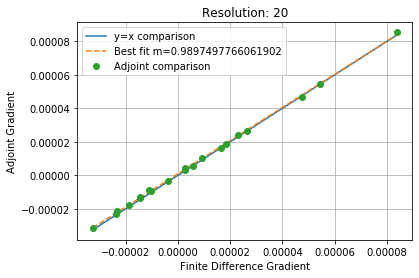

In [7]:
resolution = 20

source = [mp.Source(src,component=mp.Ez,
                    size = source_size,
                    center=source_center)]





sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=source,
                    eps_averaging=False,
                    resolution=resolution)


Far0 = mpa.Far_Coefficients(sim, NearRegions ,far_x)


ob_list = [Far0]




def J2(alpha):
    return npa.abs(alpha[0,0])**2 + npa.abs(alpha[1,5])**3


def J1(alpha):
    return npa.abs(alpha[0,0])**2


def J3(alpha):
    return npa.abs(alpha[0,2])**2 + npa.abs(alpha[0,3])**3




opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=J3,
    objective_arguments=ob_list,
    design_regions=[design_region],
    #design_variables=[design_variables],
    fcen=fcen,
    df = 0,
    nf = 1,
    decay_fields=[mp.Ez]
)




x0 = 11*np.random.rand(Nx*Ny) + 1
opt.update_design([x0])




f0, dJ_deps = opt()




g_discrete, idx = opt.calculate_fd_gradient(num_gradients=choose,db=db)
g_discrete = np.array(g_discrete)

#g_adjoint = np.sum(design_variables.get_basis_vjp(dJ_deps,dg), axis=1)

g_adjoint = dJ_deps
(m, b) = np.polyfit(np.squeeze(g_discrete), g_adjoint[idx], 1)
min_g = np.min(g_discrete)
max_g = np.max(g_discrete)
        
plt.figure()
plt.plot([min_g, max_g],[min_g, max_g],label='y=x comparison')
plt.plot([min_g, max_g],[m*min_g+b, m*max_g+b],'--',label='Best fit m='+str(m))
plt.plot(g_discrete,g_adjoint[idx],'o',label='Adjoint comparison')
plt.xlabel('Finite Difference Gradient')
plt.ylabel('Adjoint Gradient')
plt.title('Resolution: {}'.format(resolution))
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=J3,
    objective_arguments=ob_list,
    design_regions=[design_region],
    #design_variables=[design_variables],
    fcen=fcen,
    df = 0.03,
    nf = 3,
    decay_fields=[mp.Ez]
)




x0 = 11*np.random.rand(Nx*Ny) + 1
opt.update_design([x0])




f0, dJ_deps = opt()




g_discrete, idx = opt.calculate_fd_gradient(num_gradients=choose,db=db)
g_discrete = np.array(g_discrete)

#g_adjoint = np.sum(design_variables.get_basis_vjp(dJ_deps,dg), axis=1)



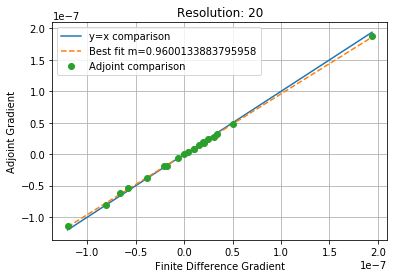

In [9]:
g_adjoint = np.sum(dJ_deps, axis=1)
(m, b) = np.polyfit(np.squeeze(g_discrete), g_adjoint[idx], 1)
min_g = np.min(g_discrete)
max_g = np.max(g_discrete)
        
plt.figure()
plt.plot([min_g, max_g],[min_g, max_g],label='y=x comparison')
plt.plot([min_g, max_g],[m*min_g+b, m*max_g+b],'--',label='Best fit m='+str(m))
plt.plot(g_discrete,g_adjoint[idx],'o',label='Adjoint comparison')
plt.xlabel('Finite Difference Gradient')
plt.ylabel('Adjoint Gradient')
plt.title('Resolution: {}'.format(resolution))
plt.legend()
plt.grid(True)
plt.show()